# Tutorial 2. DIIS

In this tutorial, we will learn:

* how to do a line search using the DIIS method

TOC
1. [Theory](#theory)
2. [Examples](#examples)

   2.1. [1D function](#example-1)
   
   2.2. [2D function](#example-2)
   
   2.3. [line search](#example-3)

In [20]:
import sys
import cmath
import math
import os

if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *
import util.libutil as comn
from libra_py import data_outs

<a name="theory"></a>
## 1. Theory

The Direct Inverse or Iterative Subspace (DIIS) method solves a function optimization problem:

$$ f(X) -> min $$

Here, $X$ could be a multidimensional object, such as a matrix. A scalar or vector are both the special cases.

The search is done with the following approach:

$ X_{n} = \sum_{i=n-N}^{n-1} c_i * X_i $

That is the optimal coordinate at the (n+1)-th iteration is predicted based on the previous N values of the guessed position of the optimal point $ {X_i}, i=n-N, ..., n-1 $ 

The coefficients ${c_i}$ are chosen to minimize the errors in previous iteractions. 

Every new predicted point, $X_n$, is eventually added to the "training set" used to determine the superposition coefficient. When this is done, the older values may eventually be replaces. So, only N latest iterations are retained and used to progress with the DIIS optimization. Obviously, the N parameter is something the user can control.  

<a name="examples"></a>
## 2. Examples

<a name="example-1"></a>
### 2.1. Example 1: Searching for a minimum of a 1D function

In this example, we show basic workflow of the operations with the DIIS procedure object.

We use it for finding a root of a function. We print all the useful information to give a better understanding of the procedures and variables

Here we will demonstrate how to apply DIIS for efficient line search in 1D so we use 1x1 matrices

First of all, lets define the function whoes minimum we want to find:

In [21]:
def func(x):
    return (x-0.456)**2

Lets define an auxiliary printing function

In [22]:
def diis_printout(diis_object):
    print("DIIS coefficients", diis_object.get_diis_c() )
    print("DIIS objective matrices and errors") 
    X = diis_object.get_diis_X()
    E = diis_object.get_diis_err()
    sz = len(X)
    for i in range(sz):
        print(F"matrix index = {i}, matrix value = {X[i].get(0)}, prediction errors = {E[i].get(0)}")

In this example, we define a 3-element predictor matrix (N = 3). 

We are interested in optimizing a scalar function, that is the one that returns only a single value. 

So, these two numbers (3 and 1) is what determines the parameters of the *DIIS* data type constructor defined in Libra.

In [23]:
diis = DIIS(3,1)
diis_printout(diis)

DIIS coefficients [0.0, 0.0, 0.0]
DIIS objective matrices and errors
matrix index = 0, matrix value = 0.0, prediction errors = 0.0
matrix index = 1, matrix value = 0.0, prediction errors = 0.0
matrix index = 2, matrix value = 0.0, prediction errors = 0.0


As we print out the content of the DIIS object, we see that is has 3 places reserved for 3 latest matrices, 3 latest prediction errors, and 3 coefficients to use in the extrapolation formula

To get the DIIS iteractions started, we need to provide at least 2 data sets. Each one consists of the coordinate matrix and the corresponding function matrix. This is done using the `add_diis_matrices` method of the `diis` object.

In [24]:
print("Adding the first set")
x = MATRIX(1,1); x.set(0, 0.0);
f = MATRIX(1,1); f.set(0, func(0.0)**2);
diis.add_diis_matrices(x, f);
diis_printout(diis)

print("Adding the second set")
x = MATRIX(1,1); x.set(0, 1.0);
f = MATRIX(1,1); f.set(0, func(1.0)**2);
diis.add_diis_matrices(x, f);
diis_printout(diis)

Adding the first set
DIIS coefficients [1.0, 0.0, 0.0]
DIIS objective matrices and errors
matrix index = 0, matrix value = 0.0, prediction errors = 0.043237380096000005
matrix index = 1, matrix value = 0.0, prediction errors = 0.0
matrix index = 2, matrix value = 0.0, prediction errors = 0.0
Adding the second set
DIIS coefficients [1.9751164278373727, -0.9751164278373727, 0.0]
DIIS objective matrices and errors
matrix index = 0, matrix value = 0.0, prediction errors = 0.043237380096000005
matrix index = 1, matrix value = 1.0, prediction errors = 0.08757811609600002
matrix index = 2, matrix value = 0.0, prediction errors = 0.0


You can observe how the allocated variables are getting populated. 

Among the values we get collected are the prediction errors. Those are computed according to the provided error function. In the present example, the error is defined as:

$$ |f(x) - 0|^2 $$

where, $f(x)$ is the function we want to optimize. The error function is defined in such a way that its minimization would correspond to the minimization of the original target function.

Note that to this point we have only computed errors at two points. The third one would be initialized within the iterative loop to follow.

Using the two points and the extrapolation coefficients we can compute the extrapolated objective matrix. This matrix contains a new guess of where the minimum of the error function may be.

Since the matrices are all 1-D, we can simply print the value after we extract it, or we can just print out the matrix. 

In [25]:
print("The extrapolated objective matrix\n")
x = MATRIX(1,1)
diis.extrapolate_matrix(x)

# Printing out the value
rt = x.get(0)
print("rt = ", rt)

# Printing out the matrix
data_outs.print_matrix(x)

The extrapolated objective matrix

rt =  -0.9751164278373727
-0.9751164278373727  


At this point, we can start the iterative process of predicting new objective matrices, and adding them to the `diis` object (meaning also computing the error functions).

We do several iterations. As we proceed with them, the objective matrix should converge to the correct solution

In [26]:
for n in range(20):
    print("==== Cycle ", n, " =========")
    print("Adding next set")
    x = MATRIX(1,1); x.set(0, rt)
    f = MATRIX(1,1); f.set(0, func(rt))
    diis.add_diis_matrices(x, f);
    diis_printout(diis)

    print("The extrapolated objective matrix\n")
    x = MATRIX(1,1)
    diis.extrapolate_matrix(x)
    data_outs.print_matrix(x)
    
    rt = x.get(0)


==== Cycle  0  =========
Adding next set
DIIS coefficients [1.0446709493860997, -0.04467094938609971, 0.0]
DIIS objective matrices and errors
matrix index = 0, matrix value = 0.0, prediction errors = 0.043237380096000005
matrix index = 1, matrix value = 1.0, prediction errors = 0.08757811609600002
matrix index = 2, matrix value = -0.9751164278373727, prediction errors = 2.048094230026002
The extrapolated objective matrix

1.0882303259795774  
==== Cycle  1  =========
Adding next set
DIIS coefficients [-0.24248984862782907, 1.242489848627829, 0.0]
DIIS objective matrices and errors
matrix index = 0, matrix value = 1.0, prediction errors = 0.08757811609600002
matrix index = 1, matrix value = -0.9751164278373727, prediction errors = 2.048094230026002
matrix index = 2, matrix value = 1.0882303259795774, prediction errors = 0.3997151850882427
The extrapolated objective matrix

1.588570967979372  
==== Cycle  2  =========
Adding next set
DIIS coefficients [1.4526776496552014, -0.452677649655

As you can observe, the value to which the objective matrix converges is the expected position of the function minimum. 

<a name="example-2"></a>
### 2.2. Example 2: Searching for a minimum of a 2D function

Now we apply the DIIS algorithm to a 2D problem. 

First, define the function which we want to optimize.

The DIIS algorithm itself only need the value of the function, and this is all what we needed in the previous example. However, as we move towards a multidimensional case, it is important to have a good set of starting points to initialize the DIIS algorithm. A good selection would be a number of points sampled along the target function's gradient. This is why, the function defined below also returns its gradients. 

Technically, in 1D case, any points are located along the direction of the gradient. That's why we didn't need to worry about that too much. Not the case in higher dimensions. 

In [27]:
def func_2D(x,y):
    return (x-0.456)**4 + (y+0.56)**4, 4.0*(x-0.456)**3, 4.0*(y+0.56)**3

Define some auxiliary functions:

In [28]:
def diis_printout_2D(diis_object):    
    print("DIIS coefficients", diis_object.get_diis_c() )
    print("DIIS objective matrices and errors")
    X = diis_object.get_diis_X()
    E = diis_object.get_diis_err()
    sz = len(X)    
    for i in range(sz):
        print(F"i = {i} x ={X[i].get(0,0)} y ={X[i].get(1,1)} error_x = {E[i].get(0,0)} error_y ={E[i].get(1,1)}" )


def add_set_2D(diis_object, x,y, verbose=True):    
    X = MATRIX(2,2);   X.set(0,0, x);  X.set(1,1, y);  
    E = MATRIX(2,2);   z = func_2D(x,y);  E.set(0,0, z[0]); E.set(1,1, z[1]); 
    diis_object.add_diis_matrices(X, E);
    if verbose==True:
        diis_printout_2D(diis_object)
        
    return z # function and its gradient

 As before, lets initialize a `diis` object and add several points to initialize it
 
In this case, our target function depends on 2 variables and we will use only 4 consecutive points to make an extrapolation. These numbers determine the parameters in the `diis` object constructor.

In [29]:
diis = DIIS(4,2)
diis_printout_2D(diis)

print("====== The first set =========")
z0 = add_set_2D(diis,  0.0, 0.0)  
diis_printout_2D(diis)

dt = 0.25
# add few steps along the direction of the negative gradient
print("====== The second set =========")
add_set_2D(diis, 0.0-dt*z0[1], 0.0-dt*z0[2])
diis_printout_2D(diis)

print("====== The third set =========")
add_set_2D(diis, 0.0-2.0*dt*z0[1], 0.0-2.0*dt*z0[2])
diis_printout_2D(diis)

print("====== The forth set =========")
add_set_2D(diis, 0.0-3.0*dt*z0[1], 0.0-3.0*dt*z0[2])
diis_printout_2D(diis)

DIIS coefficients [0.0, 0.0, 0.0, 0.0]
DIIS objective matrices and errors
i = 0 x =0.0 y =0.0 error_x = 0.0 error_y =0.0
i = 1 x =0.0 y =0.0 error_x = 0.0 error_y =0.0
i = 2 x =0.0 y =0.0 error_x = 0.0 error_y =0.0
i = 3 x =0.0 y =0.0 error_x = 0.0 error_y =0.0
====== The first set =========
DIIS coefficients [1.0, 0.0, 0.0, 0.0]
DIIS objective matrices and errors
i = 0 x =0.0 y =0.0 error_x = 0.14158234009600004 error_y =-0.37927526400000006
i = 1 x =0.0 y =0.0 error_x = 0.0 error_y =0.0
i = 2 x =0.0 y =0.0 error_x = 0.0 error_y =0.0
i = 3 x =0.0 y =0.0 error_x = 0.0 error_y =0.0
DIIS coefficients [1.0, 0.0, 0.0, 0.0]
DIIS objective matrices and errors
i = 0 x =0.0 y =0.0 error_x = 0.14158234009600004 error_y =-0.37927526400000006
i = 1 x =0.0 y =0.0 error_x = 0.0 error_y =0.0
i = 2 x =0.0 y =0.0 error_x = 0.0 error_y =0.0
i = 3 x =0.0 y =0.0 error_x = 0.0 error_y =0.0
====== The second set =========
DIIS coefficients [-0.8507300612965909, 1.850730061296591, 0.0, 0.0]
DIIS objective m

The extrapolated matrix is

In [30]:
X = MATRIX(2,2);
diis.extrapolate_matrix(X);

# Printing out the matrix
data_outs.print_matrix(X)

rt = [X.get(0,0), X.get(1,1)]
print(rt)

0.32577550929409477  0.0  
0.0  -0.6033759358500297  
[0.32577550929409477, -0.6033759358500297]


Start the iterations, as we did before, except now it is 2D

In [31]:
for n in range(15):
 
    add_set_2D(diis, rt[0],rt[1], False)   
    
    X = MATRIX(2,2);
    diis.extrapolate_matrix(X)
   
    rt = [X.get(0,0), X.get(1,1)]

    print(F" iteration = {n} predicted coordinates = {rt} the error function = {func_2D(rt[0],rt[1])[0] }")


 iteration = 0 predicted coordinates = [0.36304945857160253, -0.6724118313870379] the error function = 0.00023432530476870207
 iteration = 1 predicted coordinates = [0.3694710094840983, -0.6843053260816865] the error function = 0.00029481771388739473
 iteration = 2 predicted coordinates = [0.37738084756651635, -0.6989553099486217] the error function = 0.00041102559477546806
 iteration = 3 predicted coordinates = [0.3837981368515475, -0.7108409115899761] the error function = 0.0005448746324918594
 iteration = 4 predicted coordinates = [0.38645439545905713, -0.7157606261707148] the error function = 0.0006120068171691966
 iteration = 5 predicted coordinates = [0.38868829879135447, -0.7198980873297387] the error function = 0.0006742205961842879
 iteration = 6 predicted coordinates = [0.3901810102950165, -0.7226627699278225] the error function = 0.0007188554645626549
 iteration = 7 predicted coordinates = [0.3910267250070234, -0.7242293752475177] the error function = 0.0007452716455632151
 

Although the result isn't quite exactly what we expect, the result is quite converged.

The loss of the accuracy may be due to:

- the choice of initial points
- the length of the DIIS procedure
- the properties of the potential
- the Pythonic rounding errors


<a name="example-3"></a>
### 2.3. Example 3: Combining the line search with the gradient optimization for a 2D function

In this example, we combine the DIIS algorithm with a gradient optimization algorithm. 

To fully see the interoperation of the gradient optimization and DIIS, we use a more complex function.

In [32]:
def func_2D_2(R):
    x, y = R[0], R[1]
    f = (x**2 + y**2 + 0.1)**2 + 0.25*((x-1.0)**2 + y**2)**2
    dfdx =  4.0*x*(x**2 + y**2 + 0.1) + ((x-1.0)**2 + y**2)*(x-1.0)
    dfdy =  4.0*y*(x**2 + y**2 + 0.1) + ((x-1.0)**2 + y**2)*y

    return f, dfdx, dfdy


def add_set_2D_2(diis_object, R, verbose=True):    
    x, y = R[0], R[1]
    X = MATRIX(2,2);   X.set(0,0, x);  X.set(1,1, y);  
    E = MATRIX(2,2);   z = func_2D_2(R);  E.set(0,0, z[0]); E.set(1,1, z[1]); 
    diis_object.add_diis_matrices(X, E);
    if verbose==True:
        diis_printout_2D(diis_object)
        
    return z # function and its gradient

The following function would perform a "line" search - the search for a minimum along a line of several points. This functions essentially utilized the 2D DIIS discussed above

In [33]:
def line_search_2D(tol, dt, R, verbose=True):
    """
    This function searches for a point that delivers minimum along given direction
    The direction is given by the negative gradient of the function at the initial point
    The function modifies the initial R, to end up with the point that delivers the minimum
    The function also returns the target function and its gradient at the final point
    """

    diis = DIIS(3,2)
    X = MATRIX(2,2);  # extrapolated matrix
    diis_printout_2D(diis)


    z0 = add_set_2D_2(diis, R, verbose)     # starting point 
    val0 = z0[0]

    # Initial step
    z = add_set_2D_2(diis, [R[0]-dt*z0[1], R[1]-dt*z0[2]], verbose)
    val = z[0]

    diis.extrapolate_matrix(X);     
    R = [X.get(0,0), X.get(1,1)]

    err = math.fabs(val - val0);  val0 = val
    it = 0
    print(it, err)

    while err>tol and it < 10:
        z = add_set_2D_2(diis, R, verbose);  val = z[0]
        diis.extrapolate_matrix(X);    
        R = [X.get(0,0), X.get(1,1)]

        err = math.fabs(val - val0);  val0 = val

        it = it + 1
        print(it, err, R)

    return R, z


However, the points to define the "line" should be computed using some gradient approch. The simplest is the gradient descent, as implemented here. 

The function `test` below also defines some parameters of simulations, the choice of the initial point, as well as the implementation of the alternating DIIS and gradient descent steps. 

**VERY IMPORTANT:** to make the algorithm work, you need to use good starting guess as well as reasonable simulation parameters (stepping sizes, tolerances, etc.).

It takes trial and error sometimes to get the function minimized

In [34]:
def test():
    
    dt_ls = 0.001   # stepping size for line searching
    dt_gr = 0.0001    # stepping size for the gradient descent
    R = [0.0, 0.24] # starting point
    tol_ls = 1e-5
    tol_gr = 1e-5


    it = 0
    err = 2.0*tol_gr
    
    all_err, all_x, all_y = [], [], []
    all_err.append(err)
    all_x.append(R[0])
    all_y.append(R[1])
            
    while err>tol_gr and it<15:
        R, z = line_search_2D(tol_ls, dt_ls, R, verbose=False)
        
        print("Iter= ",it, " R= ", R, " z= ", z)
        it = it + 1

        # Gradient step    
        sz = len(R)
        err = 0.0
        for i in range(sz):
            R[i] = R[i] - dt_gr * z[1+i]
            err = err + z[1+i]**2
        err = math.sqrt(err)
        
        all_err.append(err)
        all_x.append(R[0])
        all_y.append(R[1])
        
    return all_err, all_x, all_y


The function returns the history of the error and coordiantes' progression, so that we can later plot them and study the path the convergence is achieved (or not)

In [35]:
err, x, y = test()

DIIS coefficients [0.0, 0.0, 0.0]
DIIS objective matrices and errors
i = 0 x =0.0 y =0.0 error_x = 0.0 error_y =0.0
i = 1 x =0.0 y =0.0 error_x = 0.0 error_y =0.0
i = 2 x =0.0 y =0.0 error_x = 0.0 error_y =0.0
0 0.0012801879609574685
1 0.19083478426147132 [0.2894185761648483, 0.1291364848941889]
2 0.00415908559199589 [0.3187963003799861, 0.11788317207844612]
3 0.004635581276092857 [0.3560945480233375, 0.10359585542692518]
4 0.0019046055571190212 [0.36516874959043477, 0.10011992842228201]
5 0.0002264993158792722 [0.3729914858777974, 0.09712336305851821]
6 0.0004166092145128919 [0.3782278912243271, 0.09512659417062252]
7 0.0003957284399612737 [0.38022050508186567, 0.08637529858306436]
8 0.0008383596521793352 [0.37699538560828216, -0.7334809442438335]
9 0.7211622472286265 [0.35437136598894303, 0.33051761611691244]
10 0.6417210295204798 [0.34628606096755443, 0.6533312524744814]
Iter=  0  R=  [0.34628606096755443, 0.6533312524744814]  z=  (0.18129465037868436, 0.13495267577537962, 0.6165350

Lets do some optional plotting of the convergences:

In [36]:
import matplotlib.pyplot as plt   # plots
#matplotlib.use('Agg')
#%matplotlib inline 

import numpy as np
#from matplotlib.mlab import griddata

plt.rc('axes', titlesize=24)      # fontsize of the axes title
plt.rc('axes', labelsize=20)      # fontsize of the x and y labels
plt.rc('legend', fontsize=20)     # legend fontsize
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

colors = {}

colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   

colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      

colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  

colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]

In [39]:
def plot(errors, xvals, yvals):
    
    time = list(range(len(errors)))
    
    #======== Now lets plot what we have computed ===========
    plt.figure(1, figsize=(36, 12)) # dpi=300, frameon=False)
    plt.subplot(1,3,1)
    plt.title('Error')
    plt.xlabel('Iteration')
    plt.ylabel('Error')
    plt.plot(time, errors, label='', linewidth=5, color = colors["11"])     
    plt.legend()
    
    plt.figure(1, figsize=(36, 12)) # dpi=300, frameon=False)
    plt.subplot(1,3,2)
    plt.title('Coordinates')
    plt.xlabel('Iteration')
    plt.ylabel('X')
    plt.plot(time, xvals, label='X coordinate', linewidth=5, color = colors["21"])     
    plt.legend()

    plt.figure(1, figsize=(36, 12)) # dpi=300, frameon=False)
    plt.subplot(1,3,3)
    plt.title('Coordinates')
    plt.xlabel('Iteration')
    plt.ylabel('Y')
    plt.plot(time, yvals, label='Y coordinate', linewidth=5, color = colors["31"])     
    plt.legend()


        
    plt.show()
    plt.close()

No handles with labels found to put in legend.


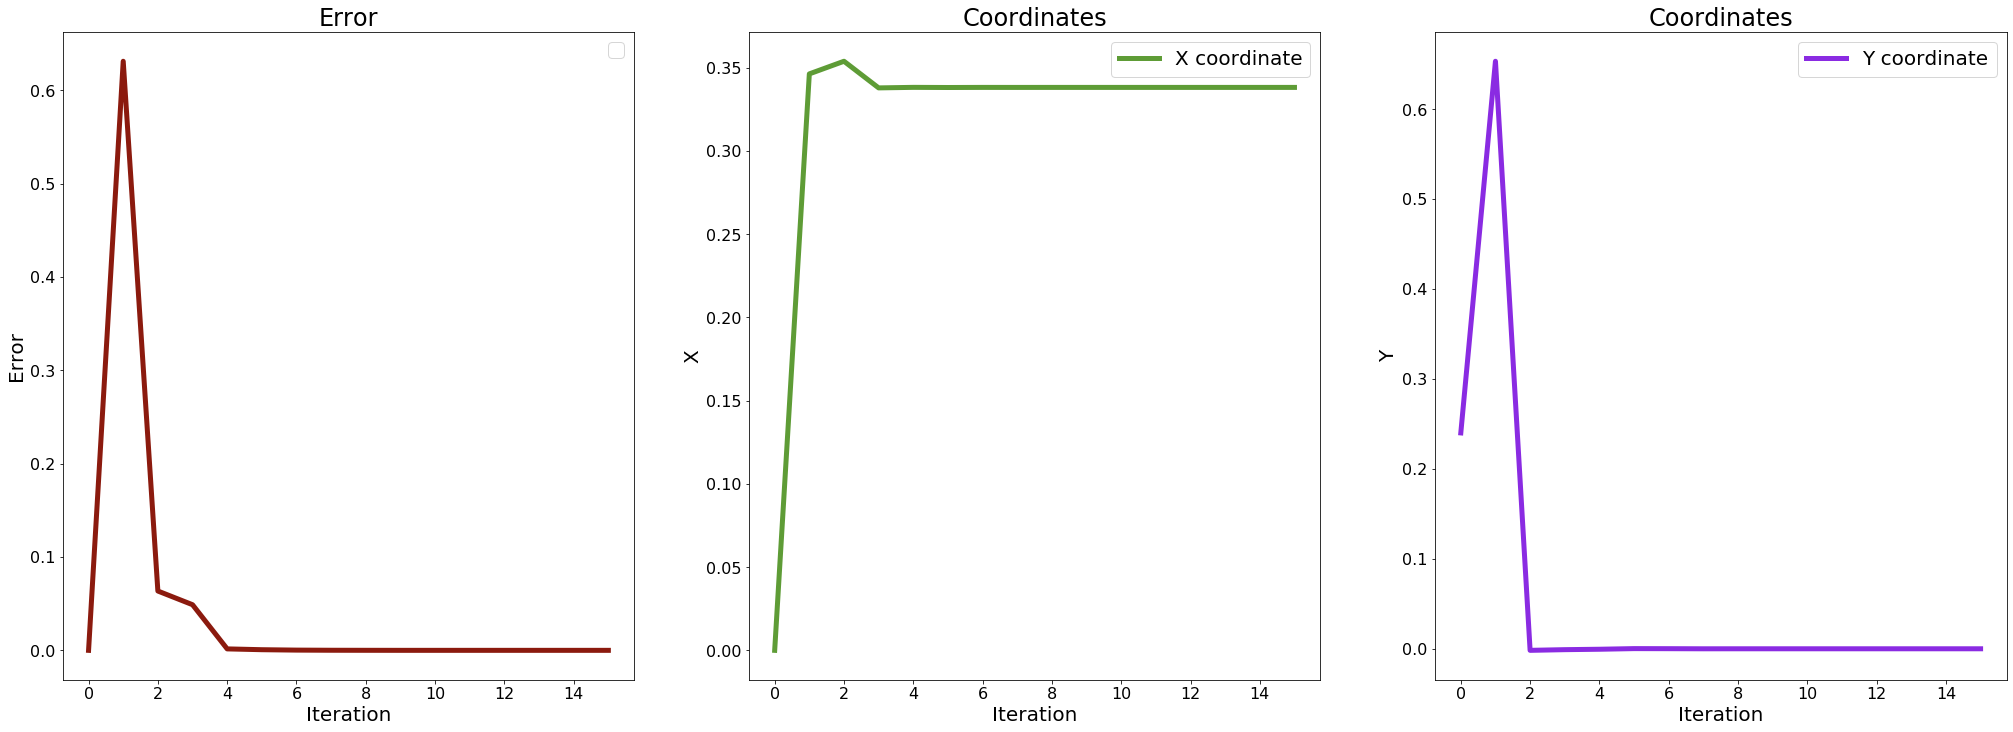

In [40]:
plot(err, x, y)